In [1]:
!pip install shap
import shap
!pip install lime
import lime
import lime.lime_tabular
!pip install aix360
from aix360.algorithms.protodash import ProtodashExplainer

import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV


import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import linear_model

from sklearn.svm import SVC

import warnings
warnings.simplefilter(action ='ignore')

# New Section

change the directory according to your dirve

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
heloc = pd.read_csv("heloc.csv")
print(heloc.shape)
#heloc.head()


(10459, 24)


# **1. EDA**

### **Label Encoding**

"Bad":1  
"Good":0

In [3]:
df= heloc.copy()
df.replace({"Bad":1, "Good":0}, inplace=True)
#df.head()

In [4]:
#df.info()

**Separating predictor features**

In [5]:
# take the label away
predictor = heloc.iloc[:, 1:].copy()
#predictor.info()

In [6]:
'''
print("SPECIAL VALUES: ")
for i in range(23):
    print(i+1, ".", predictor.iloc[:, i].name, end=': ')
    for x in predictor.iloc[:, i].unique():
        if x < 0:
            print(x, end=', ')
    print()
    '''

'\nprint("SPECIAL VALUES: ")\nfor i in range(23):\n    print(i+1, ".", predictor.iloc[:, i].name, end=\': \')\n    for x in predictor.iloc[:, i].unique():\n        if x < 0:\n            print(x, end=\', \')\n    print()\n    '

-> All predictor columns have special values

In [7]:
'''
for i in range(23):
  print(predictor.iloc[:, i].name, end=': ')
  print(predictor.iloc[:, i].unique())
  print()
  '''

"\nfor i in range(23):\n  print(predictor.iloc[:, i].name, end=': ')\n  print(predictor.iloc[:, i].unique())\n  print()\n  "

Value	Meaning

-9	: No Bureau Record or No Investigation

-8 :	No Usable/Valid Trades or Inquiries

-7: 	Condition not Met (e.g. No Inquiries, No Delinquencies)




In [8]:
# get the index of special values
'''
indices = []
for i in range(df.shape[0]):
  conditon = predictor.iloc[i, :] <0
  if conditon.any():
    indices.append(i)
# there 7957 rows have missing values which is a lot -> should not delete them
len(indices)
'''

'\nindices = []\nfor i in range(df.shape[0]):\n  conditon = predictor.iloc[i, :] <0\n  if conditon.any():\n    indices.append(i)\n# there 7957 rows have missing values which is a lot -> should not delete them\nlen(indices)\n'

**Due with Special Values**

In [9]:
# replace special valuess to nan
df.replace({-7:np.NaN, -8:np.NaN, -9:np.NaN}, inplace=True)

In [10]:
# replace nan to mean
for i in range(1,24,1):
  df.iloc[:, i] = df.iloc[:, i].fillna(df.iloc[:, i].mean())


IMPORTANCE FEATURES:
1. ExternalRiskEstimate
2.  NumTrades60Ever2DerogPubRec
3. PercentInstallTrades
4. NetFractionInstallBurden
5. NumRevolvingTradesWBalance
6. NumInstallTradesWBalance
7. PercentTradesWBalance

In [11]:
correlation_coefficient = df.iloc[:, 1:].corr().round(1)
#correlation_coefficient

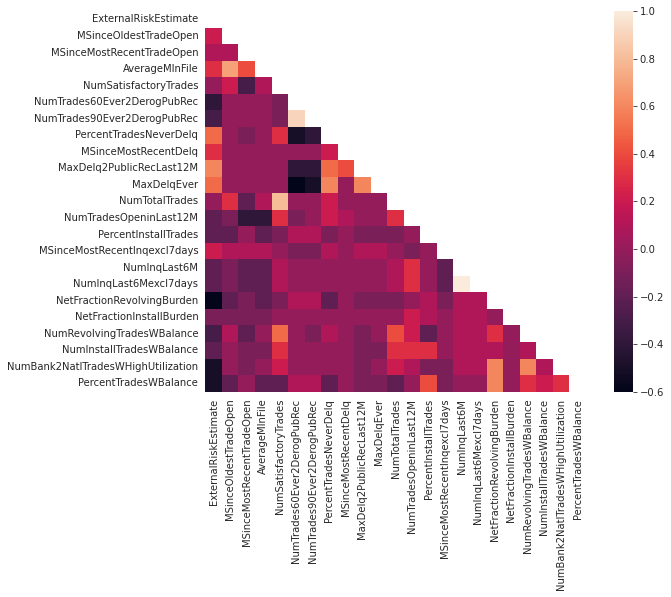

In [12]:
mask = np.zeros_like(correlation_coefficient)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(correlation_coefficient, mask=mask, vmax=1, square=True)


### **1. 1 Spliting Data**

I splited data into 3 subsets (Train, Test and Dummy)

Dummy set is used for Front end (Pay Attention **Oliver**)

Divide data into 3 subsets  
Train  
Test  
Dummy (for frontend experiment)

In [16]:
X = df.drop('RiskPerformance', axis=1)
y = df['RiskPerformance']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=8)
X_test, X_dummy, y_test, y_dummy = train_test_split(X_test, y_test, test_size=0.002, random_state=8)


In [14]:
# data for Frontend
#X_dummy

# **2. Train model**

***3 models: XGBoost, Decision Tree and Support Vector Machine***

## **Neural Network**   (Dont use this)
Give 70% accuracy but Can't get the shap to work on this model

In [15]:
#X = df.drop('RiskPerformance', axis=1).to_numpy()
#Y = df['RiskPerformance'].to_numpy()

#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

#neural_net = make_pipeline(
    #StandardScaler(),
    #MLPClassifier(hidden_layer_sizes=(3,),activation='relu',solver='adam',  max_iter=10000,learning_rate='constant',random_state=0, early_stopping=True)   
#)

#neural_net.fit(X_train, y_train)

#neural_net.predict_proba(X_test[0:])

#neural_net.score(X_test, y_test)

#explainer = shap.KernelExplainer(neural_net.predict,X_train)

#shap_values = explainer.shap_values(X_test,nsamples=100)

#shap.summary_plot(shap_values,X_test,feature_names=features)

## **2.1 XGBOOST**

**Build model**

[08:19:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "col_sample_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




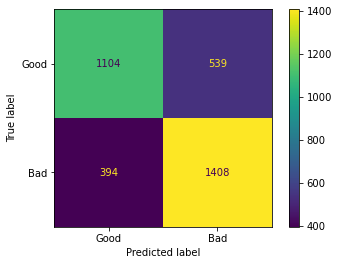

In [16]:
xgb_model = xgb.XGBClassifier(objective="reg:logistic", 
                              seed=70, 
                              col_sample_bytree=0.4,
                              learning_rate= 0.01, 
                              max_depth= 5,
                              n_estimators=500,
                              alpha=10)

xgb_model.fit(X_train.values, y_train)
plot_confusion_matrix(xgb_model,X_test.values,  y_test, values_format='d', display_labels =["Good", "Bad"]  )

In [17]:
xgb_pred = xgb_model.predict(X_test.values)
print('Training accuracy:', accuracy_score(y_train, xgb_model.predict(X_train.values)))
print('Test accuracy:', accuracy_score(y_test, xgb_pred))
print('ROC_AUC: ', roc_auc_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred, target_names=["Approved", "Denied"]))

Training accuracy: 0.7493934636791779
Test accuracy: 0.7291727140783745
ROC_AUC:  0.7266478106763096
              precision    recall  f1-score   support

    Approved       0.74      0.67      0.70      1643
      Denied       0.72      0.78      0.75      1802

    accuracy                           0.73      3445
   macro avg       0.73      0.73      0.73      3445
weighted avg       0.73      0.73      0.73      3445



In [18]:
# feature importance
#plot_importance(xgb_model, )


Create a test dataframe which consists of actual label and predicted label

In [19]:
test = y_test.to_frame()
test['predict'] = xgb_pred
test.rename(columns={"RiskPerformance":"actual"}, inplace=True)
test.sample(5)

actual  predict
97       0.0        1
5654     1.0        1
6900     0.0        0
6972     1.0        1
6430     1.0        1

In [20]:
'''
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=predictor.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')
'''

"\nexplainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, \n                                                   feature_names=predictor.columns, \n                                                   verbose=True, \n                                                   class_names=['Approved', 'Denied'],\n                                                   mode='classification')\n"

Separating approved and denied observations from test set

In [21]:
denied = test[test['predict']== 1].index
approved = test[test['predict']== 0].index


***Visualizing Bad observations*** based on prediction




Observation 1:

In [22]:
'''
denied_index =np.random.choice(denied )
print(y_test.loc[denied_index])
X_test.loc[denied_index]
'''

'\ndenied_index =np.random.choice(denied )\nprint(y_test.loc[denied_index])\nX_test.loc[denied_index]\n'

In [23]:
'''
print('Predict:',test.loc[denied_index, "predict"])
#xgb_model.predict(X_test.loc[bad_index])[0]
print("Actual:" , test.loc[denied_index, 'actual'])

exp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\nprint(\'Predict:\',test.loc[denied_index, "predict"])\n#xgb_model.predict(X_test.loc[bad_index])[0]\nprint("Actual:" , test.loc[denied_index, \'actual\'])\n\nexp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 2:
Wrong Prediction

In [24]:
'''
wrong_predit = []
for i in test.index:
  if test.loc[i, 'predict'] == 1 :
    if test.loc[i, 'actual'] == 0:
      wrong_predit.append(i)
'''

"\nwrong_predit = []\nfor i in test.index:\n  if test.loc[i, 'predict'] == 1 :\n    if test.loc[i, 'actual'] == 0:\n      wrong_predit.append(i)\n"

In [25]:
'''
bad_index =np.random.choice(wrong_predit)
print('Predict:',test.loc[denied_index, "predict"])
print("Actual:" , test.loc[denied_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[denied_index ],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\nbad_index =np.random.choice(wrong_predit)\nprint(\'Predict:\',test.loc[denied_index, "predict"])\nprint("Actual:" , test.loc[denied_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[denied_index ],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 3:

In [26]:
'''
bad_index =np.random.choice(denied)
print('Predict:',test.loc[denied_index, "predict"])
print("Actual:" , test.loc[denied_index, 'actual'])

exp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\nbad_index =np.random.choice(denied)\nprint(\'Predict:\',test.loc[denied_index, "predict"])\nprint("Actual:" , test.loc[denied_index, \'actual\'])\n\nexp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

***Visualising Good Observations***

Observation 1:

In [27]:
'''
approved_index =np.random.choice(approved)
print(y_test.loc[approved_index])
X_test.loc[approved_index]
'''

'\napproved_index =np.random.choice(approved)\nprint(y_test.loc[approved_index])\nX_test.loc[approved_index]\n'

In [28]:
'''
approved_index =np.random.choice(approved)
print('Predict:',test.loc[approved_index, "predict"])
print("Actual:" , test.loc[approved_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\napproved_index =np.random.choice(approved)\nprint(\'Predict:\',test.loc[approved_index, "predict"])\nprint("Actual:" , test.loc[approved_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 2:

In [29]:
'''
approved_index =np.random.choice(approved)
print('Predict:',test.loc[approved_index, "predict"])
print("Actual:" , test.loc[approved_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\napproved_index =np.random.choice(approved)\nprint(\'Predict:\',test.loc[approved_index, "predict"])\nprint("Actual:" , test.loc[approved_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 3: Wrong Prediction

In [30]:
'''
wrong_predit = []
for i in test.index:
  if test.loc[i, 'predict'] == 0 :
    if test.loc[i, 'actual'] == 1:
      wrong_predit.append(i)

approved_index =np.random.choice(wrong_predit)
print('Predict:',test.loc[approved_index, "predict"])
print("Actual:" , test.loc[approved_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\nwrong_predit = []\nfor i in test.index:\n  if test.loc[i, \'predict\'] == 0 :\n    if test.loc[i, \'actual\'] == 1:\n      wrong_predit.append(i)\n\napproved_index =np.random.choice(wrong_predit)\nprint(\'Predict:\',test.loc[approved_index, "predict"])\nprint("Actual:" , test.loc[approved_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

# **2.2 Decision Tree**

In [58]:
new_list = []

for k in range(10,23):
    # parameter tunning for DT
    dt_model = DecisionTreeClassifier(max_leaf_nodes = k, random_state=0, criterion='entropy',
                                      max_depth=None, min_samples_split=2,
                                      splitter='best', min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                      max_features = None, 
                                     )
    fit=dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    new_list.append(accuracy_score(y_test,dt_pred))

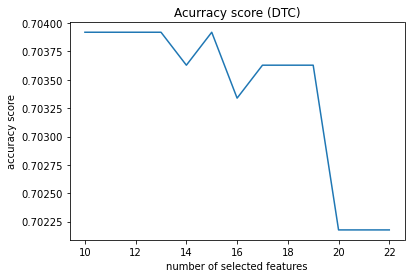

In [59]:
plt.plot(list(range(10,23)), new_list)
plt.title("Acurracy score (DTC)")
plt.xlabel('number of selected features')
plt.ylabel('accuracy score')
plt.show()

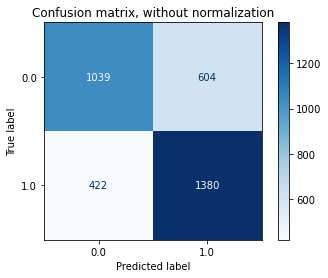

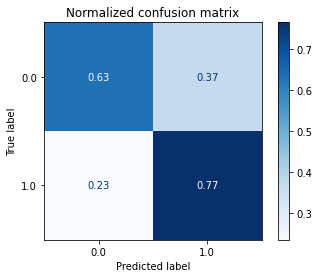

In [60]:
# confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dt_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [61]:
# classification report
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.63      0.67      1643
         1.0       0.70      0.77      0.73      1802

    accuracy                           0.70      3445
   macro avg       0.70      0.70      0.70      3445
weighted avg       0.70      0.70      0.70      3445



In [35]:
#model_dt = DecisionTreeClassifier().fit(X_train, y_train)
probs_dt = dt_model.predict_proba(X_test)[:, 1]

In [37]:
auc_dt = roc_auc_score(y_test, probs_dt)
#fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_int, probs_dt)
auc_dt

0.7572000205357813

In [17]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [55]:
DecisionTreeClassifier(max_depth=1,
 max_features=23, max_leaf_nodes=40, min_samples_leaf=5,
 min_samples_split=2, min_weight_fraction_leaf=0.1)
y_pred = dt.predict(X_test)
y_pred

array([1., 0., 1., ..., 0., 0., 0.])

In [56]:
# classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60      1643
         1.0       0.64      0.64      0.64      1802

    accuracy                           0.62      3445
   macro avg       0.62      0.62      0.62      3445
weighted avg       0.62      0.62      0.62      3445



# 2.3 Support Vector Machine

In [38]:
# fit model
svc = SVC(kernel='rbf', probability=True)
svc_model= svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, svc_pred))

Accuracy score: 0.7236574746008708


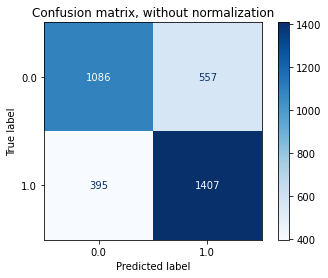

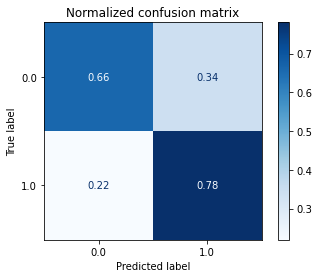

In [39]:
# confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [40]:
# classification report
print(classification_report(y_test,svc_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.66      0.70      1643
         1.0       0.72      0.78      0.75      1802

    accuracy                           0.72      3445
   macro avg       0.72      0.72      0.72      3445
weighted avg       0.72      0.72      0.72      3445



# **3. Global & Instances Explaination**

https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

https://www.kaggle.com/code/yohanb/explaining-xgb-model-with-lime/notebook

## **3.1 XGBoost**

### **3.1.1 Global Explaination by SHAP** (use train set)

In [41]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

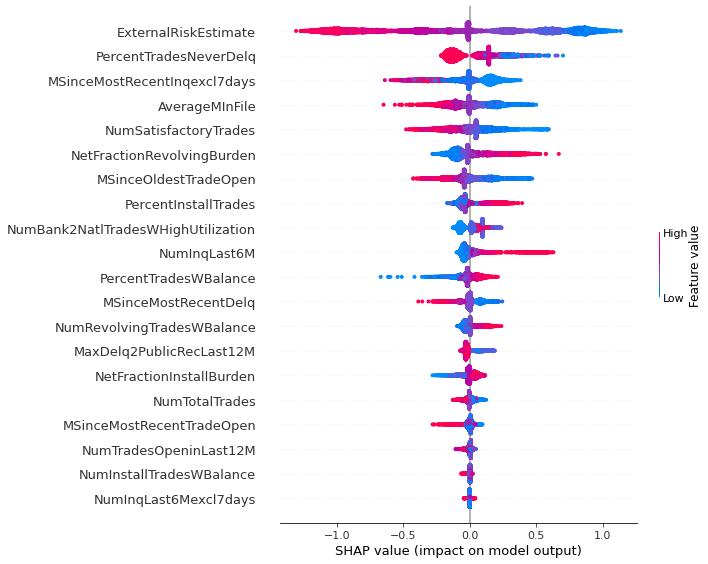

In [42]:
shap.summary_plot(shap_values, X_train)
# denied is 1
# approved is 0

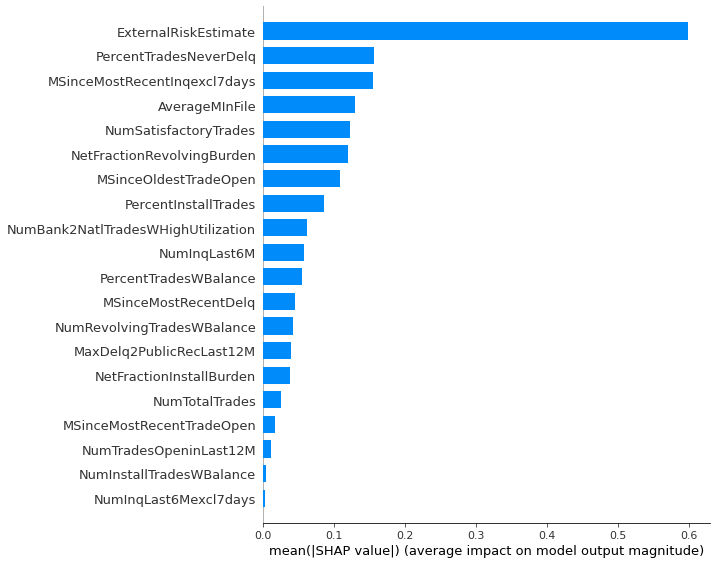

In [43]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [ ]:
'''
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df
'''

"\nshap_sum = np.abs(shap_values).mean(axis=0)\nimportance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T\nimportance_df.columns = ['column_name', 'shap_importance']\nimportance_df = importance_df.sort_values('shap_importance', ascending=False)\nimportance_df\n"

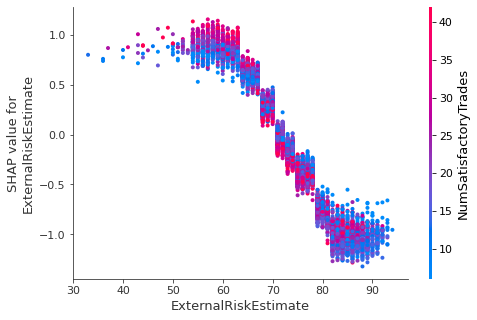

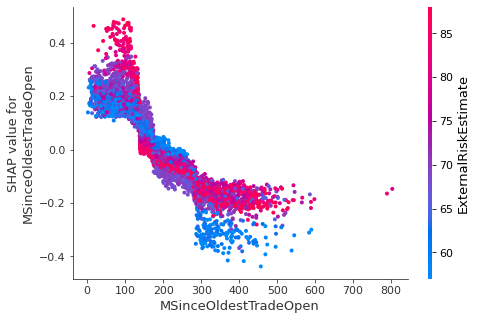

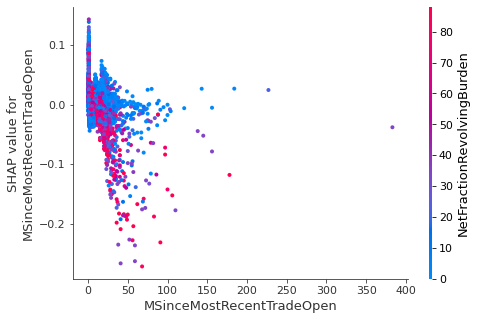

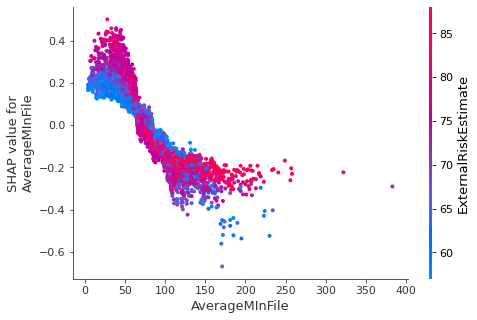

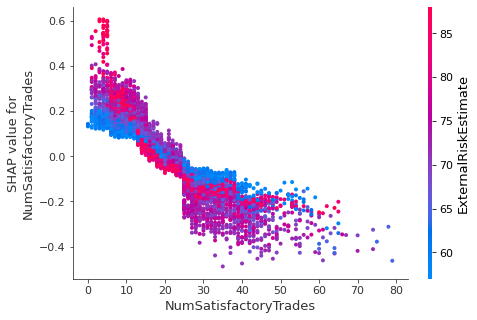

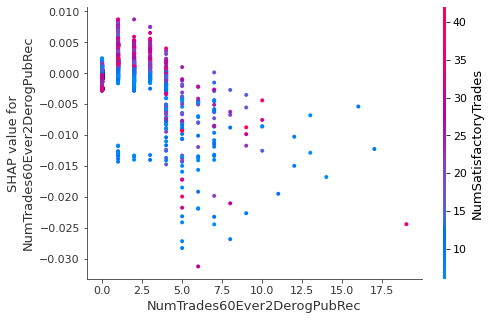

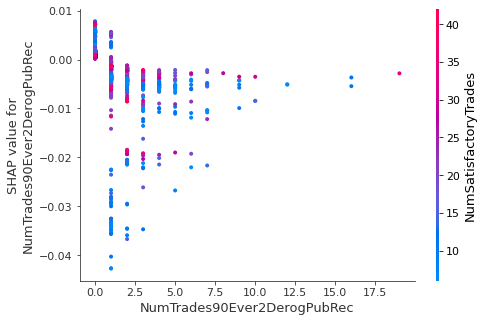

In [ ]:
for i in range(7):
  shap.dependence_plot(i, shap_values, X_train)


In [ ]:
# xgb_model.get_booster().feature_names = None

In [ ]:
# partial dependence of final prediction on ExternalRiskEstimate

# shap.partial_dependence_plot(
#     "ExternalRiskEstimate", xgb_model.predict, X_train, model_expected_value=True,
#     feature_expected_value=True, ice=False
# )

In [ ]:
# # partial dependence of final prediction on Mons Since MostRecentInqexcl7days
# shap.partial_dependence_plot(
#     "MSinceMostRecentInqexcl7days", xgb_model.predict, X_train, model_expected_value=True,
#     feature_expected_value=True, ice=False
# )

In [ ]:
# partial dependence of final prediction on PercentTradesNeverDelq
# shap.partial_dependence_plot(
#     "PercentTradesNeverDelq", xgb_model.predict, X_train, model_expected_value=True,
#     feature_expected_value=True, ice=False
# )

### **3.1.2 Local Explaination by LIME** (use Dummy data)

In [44]:
'''
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=predictor.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')
'''


"\nexplainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, \n                                                   feature_names=predictor.columns, \n                                                   verbose=True, \n                                                   class_names=['Approved', 'Denied'],\n                                                   mode='classification')\n"

In [45]:
#cols_when_model_builds = xgb_model.get_booster().feature_names

In [47]:
# Explain individual prediction using LimeTabularExplainer
#cols_when_model_builds = xgb_model.get_booster().feature_names

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')


# For example, predict the 1st observation on dumm dataset
X_dummy_observation = X_dummy.iloc[0]
        # This is for front-end to pick the observation 
explanation = explainer.explain_instance(X_dummy_observation.values, xgb_model.predict_proba)



Intercept 0.4097318436982516
Prediction_local [0.87809609]
Right: 0.90090525


In [48]:
explanation.show_in_notebook()

** tabular format ** 

In [ ]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T

0
ExternalRiskEstimate <= 65.00                      0.22
MSinceMostRecentInqexcl7days <= 0.00               0.07
AverageMInFile <= 58.00                            0.07
NumInqLast6M > 2.00                                0.05
MSinceOldestTradeOpen <= 140.00                    0.05
10.00 < NetFractionRevolvingBurden <= 33.00       -0.03
MSinceMostRecentDelq <= 16.00                      0.02
0.00 < NumBank2NatlTradesWHighUtilization <= 1.00  0.02
22.00 < PercentInstallTrades <= 33.00             -0.02
MaxDelq2PublicRecLast12M <= 6.00                   0.02



---



### **3.1.3 Local Explanation by ProtoDash**


---



---


In [ ]:
#!pip install aix360
#from aix360.algorithms.protodash import ProtodashExplainer

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
### for front end, please use the function with the parameter 'client_database'
### for protodash to work we need to have the database from which we can extract similar clients; 
### this database is the heloc.csv itself in our case
'''
def display_similar_clients(ml_model, user_input, client_database): 

    good_client_con = client_database['RiskPerformance'] == 0
    good_client_profiles = client_database[good_client_con]

    bad_client_con = client_database['RiskPerformance'] == 1
    bad_client_profiles = client_database[bad_client_con]


    index = ['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance']
    pred_dummy = ml_model.predict(np.array(user_input).reshape(1,-1))[0]
    dummy_applicant = pd.concat([pd.Series({'RiskPerformance':pred_dummy}), pd.Series(user_input, index=index)], axis=0)
    dummy_applicant = pd.DataFrame(dummy_applicant)
    dummy_applicant = dummy_applicant.T.replace({'RiskPerformance':{0.0:'pred: approve', 1.0:'pred: decline'}}).T
    dummy_applicant = dummy_applicant.rename(columns={0:'User Input'})

    if pred_dummy == 1.0:

        explainer = ProtodashExplainer()
        W, S, SetValues = explainer.explain(np.array(user_input).reshape(1,-1), bad_client_profiles.iloc[:, 1:].to_numpy(), m=3)

        similar_clients = bad_client_profiles.iloc[S, :]
        similar_clients = similar_clients.reset_index(drop=True)
        similar_clients = similar_clients.replace({'RiskPerformance':{'Good':'approve', 'Bad':'deny'}})
        similar_clients = similar_clients.rename(index={0:'Existing Client 1', 1:'Existing Client 2', 2:'Existing Client 3'})
        similar_clients = similar_clients.T
        similar_clients = pd.concat([dummy_applicant, similar_clients], axis=1)

    else:

        explainer = ProtodashExplainer()
        W, S, SetValues = explainer.explain(np.array(user_input).reshape(1,-1), good_client_profiles.iloc[:, 1:].to_numpy(), m=3)

        similar_clients = good_client_profiles.iloc[S, :]
        similar_clients = similar_clients.reset_index(drop=True)
        similar_clients = similar_clients.replace({'RiskPerformance':{'Good':'approve', 'Bad':'deny'}})
        similar_clients = similar_clients.rename(index={0:'Existing Client 1', 1:'Existing Client 2', 2:'Existing Client 3'})
        similar_clients = similar_clients.T
        similar_clients = pd.concat([dummy_applicant, similar_clients], axis=1)


    slice_idx = pd.IndexSlice
    slice_ = slice_idx[slice_idx['ExternalRiskEstimate':], slice_idx['Existing Client 1':'Existing Client 3']]
    return similar_clients.style.apply(lambda x: (abs((x+1e-10)/(similar_clients.iloc[1:, 0]+1e-10) - 1) <= 0.2).map({True:'background-color: yellow', False: ''}), subset=slice_).set_precision(0)
'''

"\ndef display_similar_clients(ml_model, user_input, client_database): \n\n    good_client_con = client_database['RiskPerformance'] == 0\n    good_client_profiles = client_database[good_client_con]\n\n    bad_client_con = client_database['RiskPerformance'] == 1\n    bad_client_profiles = client_database[bad_client_con]\n\n\n    index = ['ExternalRiskEstimate', 'MSinceOldestTradeOpen',\n       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',\n       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',\n       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',\n       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',\n       'NumTradesOpeninLast12M', 'PercentInstallTrades',\n       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',\n       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',\n       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',\n       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBal

dummy 0

In [ ]:
## to test from front end, please use the following ways to generate client database and dummy applicants' inputs
## for protodash to work, the user inputs cannot be exactly the same as one of the instances in the client_database, 
## so it would be better if an extremely small number is added to each of the user inputs 
## e.g. see what i did for the 'dummy applicant - declined' below, where the values are extracted from existing database
# %%capture

#load model
# xgb_model = xgb.XGBClassifier()
# xgb_model.load_model('xgb.model')

#random user input
#user_input = random.sample(list(range(100)), 23)

#dummpy applicant - declined:
#user_declined = [i+1e-10 for i in client_database.iloc[0, 1:]] 

#dummpy applicant - approved:
#user_approved = [i+1e-10 for i in client_database.iloc[10, 1:]]

#load the client database
#client_database_path = "heloc_dataset_v1.csv"
#client_database = pd.read_csv("heloc_dataset_v1.csv")
#client_database.replace({-7:np.NaN, -8:np.NaN, -9:np.NaN}, inplace=True)
#for i in range(1,24,1):
    #client_database.iloc[:, i] = client_database.iloc[:, i].fillna(client_database.iloc[:, i].mean().round())
'''
client_database = X_train.copy()   
client_database['RiskPerformance'] = y_train.values

# impletement protodash
df_only = display_similar_clients(xgb_model, X_dummy.iloc[0], client_database)
display(df_only)
'''

"\nclient_database = X_train.copy()   \nclient_database['RiskPerformance'] = y_train.values\n\n# impletement protodash\ndf_only = display_similar_clients(xgb_model, X_dummy.iloc[0], client_database)\ndisplay(df_only)\n"

In [ ]:
def display_similar_clients(ml_model, user_input): 
  
  '''
   take in user's input (as a list) for prediction; 
   
   '''
  
  # sourcing from X_train and y_train, put all 'good' samples together, all 'bad' samples together
  existing_client_profiles = pd.concat([y_train, X_train], axis=1)

  good_client_con = existing_client_profiles.copy()['RiskPerformance'] == 0.0
  good_client_profiles = X_train.loc[good_client_con, :]

  bad_client_con = existing_client_profiles.copy()['RiskPerformance'] == 1.0
  bad_client_profiles = X_train.loc[bad_client_con, :]

  # make prediction on user input

  index = ['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance']
  pred_dummy = ml_model.predict(np.array(user_input).reshape(1,-1))[0]
  dummy_applicant = pd.concat([pd.Series(user_input, index=index), pd.Series({'RiskPerformance':pred_dummy})], axis=0)
  dummy_applicant = pd.DataFrame(dummy_applicant)
  dummy_applicant = dummy_applicant.T.replace({'RiskPerformance':{0.0:'pred: approve', 1.0:'pred: decline'}}).T
  dummy_applicant = dummy_applicant.rename(columns={0:'User Input'})


  # implement protodash
  ## if prediction is 1.0, stack the dummy applicant with exsiting 'bad' applicants
  ## if prediction is 0.0, stack the dummy applicant with existing 'good' applicants

  if pred_dummy == 1.0:

    explainer = ProtodashExplainer()
    W, S, SetValues = explainer.explain(np.array(user_input).reshape(1,-1), bad_client_profiles.values, m=3)

    similar_clients = bad_client_profiles.iloc[S, :]
    similar_clients = similar_clients.reset_index(drop=True)
    y_bad = y_train[bad_client_con]
    similar_clients['RiskPerformance'] = y_bad.iloc[S].values
    similar_clients = similar_clients.replace({'RiskPerformance':{0.0:'approve', 1.0:'deny'}})
    similar_clients = similar_clients.rename(index={0:'Existing Client 1', 1:'Existing Client 2', 2:'Existing Client 3'})
    similar_clients = similar_clients.T
    similar_clients = pd.concat([dummy_applicant, similar_clients], axis=1)

  else:

    explainer = ProtodashExplainer()
    W, S, SetValues = explainer.explain(np.array(user_input).reshape(1,-1), good_client_profiles.values, m=3)

    similar_clients = good_client_profiles.iloc[S, :]
    similar_clients = similar_clients.reset_index(drop=True)
    y_good = y_train[good_client_con]
    similar_clients['RiskPerformance'] = y_good.iloc[S].values
    similar_clients = similar_clients.replace({'RiskPerformance':{0.0:'approve', 1.0:'deny'}})
    similar_clients = similar_clients.rename(index={0:'Existing Client 1', 1:'Existing Client 2', 2:'Existing Client 3'})
    similar_clients = similar_clients.T
    similar_clients = pd.concat([dummy_applicant, similar_clients], axis=1)


  slice_idx = pd.IndexSlice
  slice_ = slice_idx[slice_idx[:'PercentTradesWBalance'], slice_idx['Existing Client 1':'Existing Client 3']]
  return similar_clients.style.apply(lambda x: (abs((x+1e-10)/(similar_clients['User Input'][:-1]+1e-10) - 1) <= 0.2).map({True:'background-color: yellow', False: ''}), subset=slice_).set_precision(0)


In [ ]:
dummy_idx = 0
user_input = [i for i in X_dummy.iloc[dummy_idx,:].values]
display_similar_clients(xgb_model, user_input)

## **3.2 Decision Tree**

### **3.2.1 Global Explaination by SHAP**

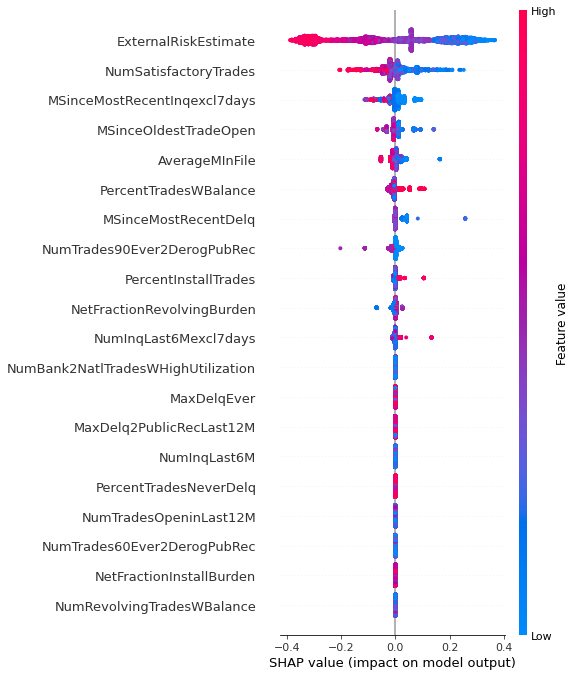

In [ ]:
# explian global model using TreeExplainer
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)

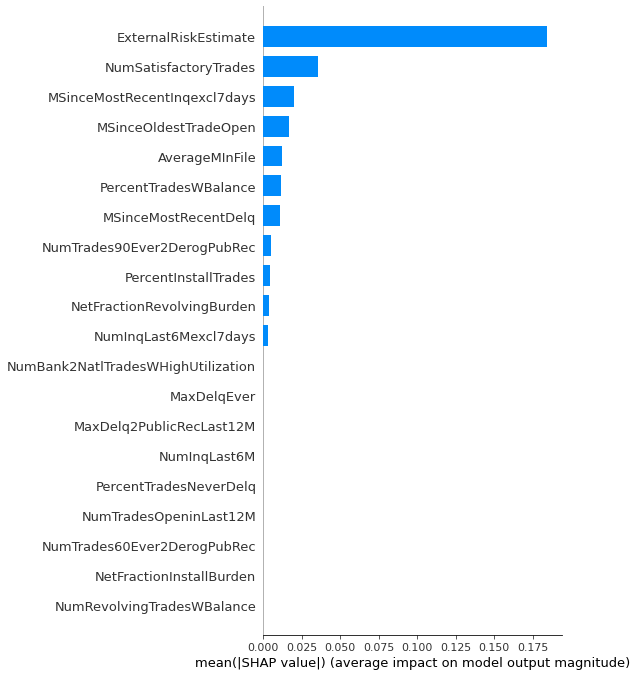

In [ ]:
shap.summary_plot(shap_values[1], X_train, plot_type='bar')

In [ ]:
# for i in range(7):
#   shap.dependence_plot(i, shap_values, X_train)

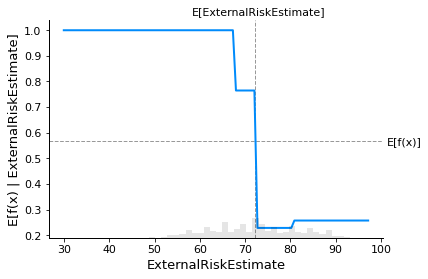

In [ ]:
shap.partial_dependence_plot(
    "ExternalRiskEstimate", dt_model.predict, X_train, model_expected_value=True,
    feature_expected_value=True, ice=False
)

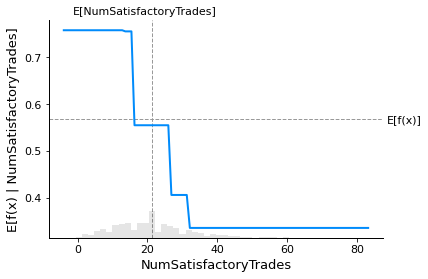

In [ ]:
shap.partial_dependence_plot(
    "NumSatisfactoryTrades", dt_model.predict, X_train, model_expected_value=True,
    feature_expected_value=True, ice=False
)

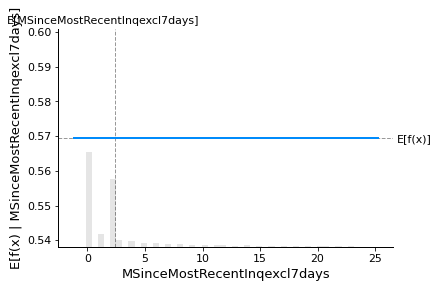

In [ ]:
shap.partial_dependence_plot(
    "MSinceMostRecentInqexcl7days", dt_model.predict, X_train, model_expected_value=True,
    feature_expected_value=True, ice=False
)

### 3.2.2 Local Explaination by LIME

In [49]:
# Explain individual prediction using LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')

In [50]:
# storing a new observation
# i = random.randint(0, len(X_test))
# X_observation = X_test.iloc[i, :]


# For example, LIME explain the prediction on the 1st observation of dummy dataset
X_dummy_observation = X_dummy.iloc[0]        # This is for front-end to pick the observation 
explanation = explainer.explain_instance(X_dummy_observation.values, dt_model.predict_proba)
explanation.show_in_notebook()

Intercept 0.388425188366874
Prediction_local [0.89421639]
Right: 0.7864450127877238


** tabular format **

In [ ]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T

0
ExternalRiskEstimate <= 65.00              0.30
MSinceMostRecentDelq <= 16.00              0.06
MSinceMostRecentInqexcl7days <= 0.00       0.04
MSinceOldestTradeOpen <= 140.00            0.03
AverageMInFile <= 58.00                    0.03
NumInqLast6Mexcl7days > 2.00               0.02
NumTrades90Ever2DerogPubRec <= 0.00        0.02
2.00 < NumTradesOpeninLast12M <= 3.00      0.01
22.00 < PercentInstallTrades <= 33.00     -0.01
4.00 < NumRevolvingTradesWBalance <= 5.00 -0.01



---







In [ ]:
# Another example, LIME explain the prediction on the 4th observation of dummy dataset
dummy_idx = 0
X_dummy_observation = X_dummy.iloc[dummy_idx]         
explanation = explainer.explain_instance(X_dummy_observation.values, dt_model.predict_proba)
explanation.show_in_notebook()

Intercept 0.3735751964470977
Prediction_local [0.91264402]
Right: 0.7864450127877238


** tabular format **

In [ ]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T

0
ExternalRiskEstimate <= 65.00              0.31
MSinceMostRecentDelq <= 16.00              0.07
MSinceMostRecentInqexcl7days <= 0.00       0.04
NumTrades90Ever2DerogPubRec <= 0.00        0.03
AverageMInFile <= 58.00                    0.03
MSinceOldestTradeOpen <= 140.00            0.03
13.00 < NumSatisfactoryTrades <= 21.00     0.02
4.00 < NumRevolvingTradesWBalance <= 5.00  0.01
NumInqLast6Mexcl7days > 2.00               0.01
50.00 < PercentTradesWBalance <= 67.00    -0.01



---



---



### 3.2.3 Local Explaination by ProtoDash

In [ ]:
dummy_idx = 0
user_input = [i for i in X_dummy.iloc[dummy_idx,:].values]
display_similar_clients(dt_model, user_input)

## **3.3 Support Vector Machine**





### **3.3.1 Global Explaination by SHAP**

In [ ]:
# Explain global model using KernelExplainer
X_shap_svc_testsample = shap.utils.sample(X_train, 20)
explainer_all = shap.KernelExplainer(model=svc.predict_proba, data=X_shap_svc_testsample, link="logit")

In [ ]:
explainer = shap.KernelExplainer(model=svc.predict_proba,data=X_shap_svc_testsample)

In [ ]:
# Be patient! This'll take a while to run. We can modify the number of test sample,the bigger sample the longer it runs. 
shap_values = explainer.shap_values(X_shap_svc_testsample, approximate=True)

  0%|          | 0/20 [00:00<?, ?it/s]

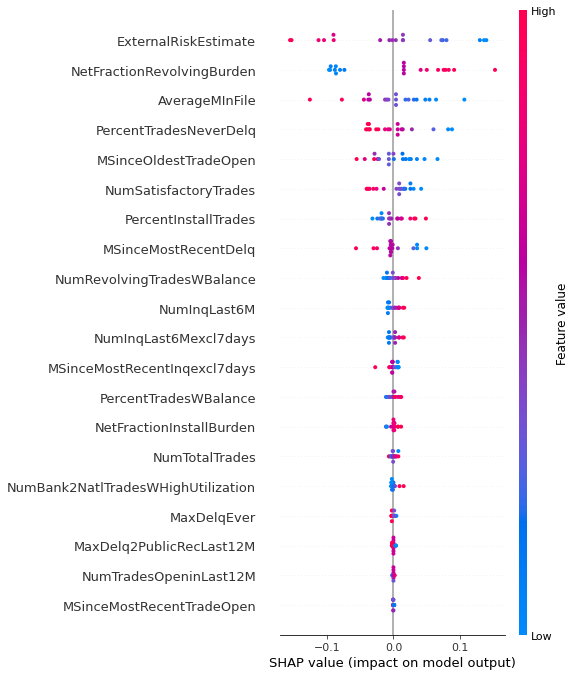

In [ ]:
shap.summary_plot(shap_values[1], X_shap_svc_testsample)

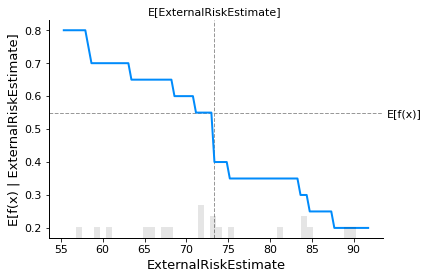

In [ ]:
shap.partial_dependence_plot(
    "ExternalRiskEstimate", svc_model.predict, X_shap_svc_testsample, model_expected_value=True,
    feature_expected_value=True, ice=False
)

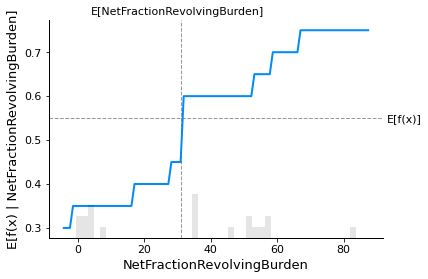

In [ ]:
shap.partial_dependence_plot(
    "NetFractionRevolvingBurden", svc_model.predict, X_shap_svc_testsample, model_expected_value=True,
    feature_expected_value=True, ice=False
)

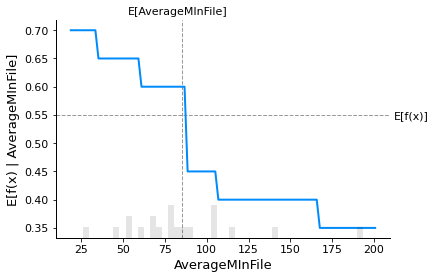

In [ ]:
shap.partial_dependence_plot(
    "AverageMInFile", svc_model.predict, X_shap_svc_testsample, model_expected_value=True,
    feature_expected_value=True, ice=False
)

### 3.3.2 Local Explaination by LIME

In [ ]:
# Explain individual prediction using LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')

In [ ]:
# For example, LIME explain the prediction on the 4th observation of dummy dataset
dummy_idx = 0
X_dummy_observation = X_dummy.iloc[dummy_idx]      
explanation = explainer.explain_instance(X_dummy_observation.values, svc_model.predict_proba)
explanation.show_in_notebook()

Intercept 0.4431478130466589
Prediction_local [0.86230702]
Right: 0.8201684388666842


** tabular format **

In [ ]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T

0
ExternalRiskEstimate <= 65.00                0.18
AverageMInFile <= 58.00                      0.11
MSinceOldestTradeOpen <= 140.00              0.07
10.00 < NetFractionRevolvingBurden <= 33.00 -0.06
MSinceMostRecentDelq <= 16.00                0.05
NetFractionInstallBurden > 79.00             0.02
NumInqLast6M > 2.00                          0.02
13.00 < NumSatisfactoryTrades <= 21.00       0.01
MSinceMostRecentInqexcl7days <= 0.00         0.01
NumInqLast6Mexcl7days > 2.00                 0.01



---



---



### 3.3.3 Local Explaination by ProtoDash


In [ ]:
dummy_idx = 0
user_input = [i for i in X_dummy.iloc[dummy_idx,:].values]
display_similar_clients(svc_model, user_input)